# Transformers

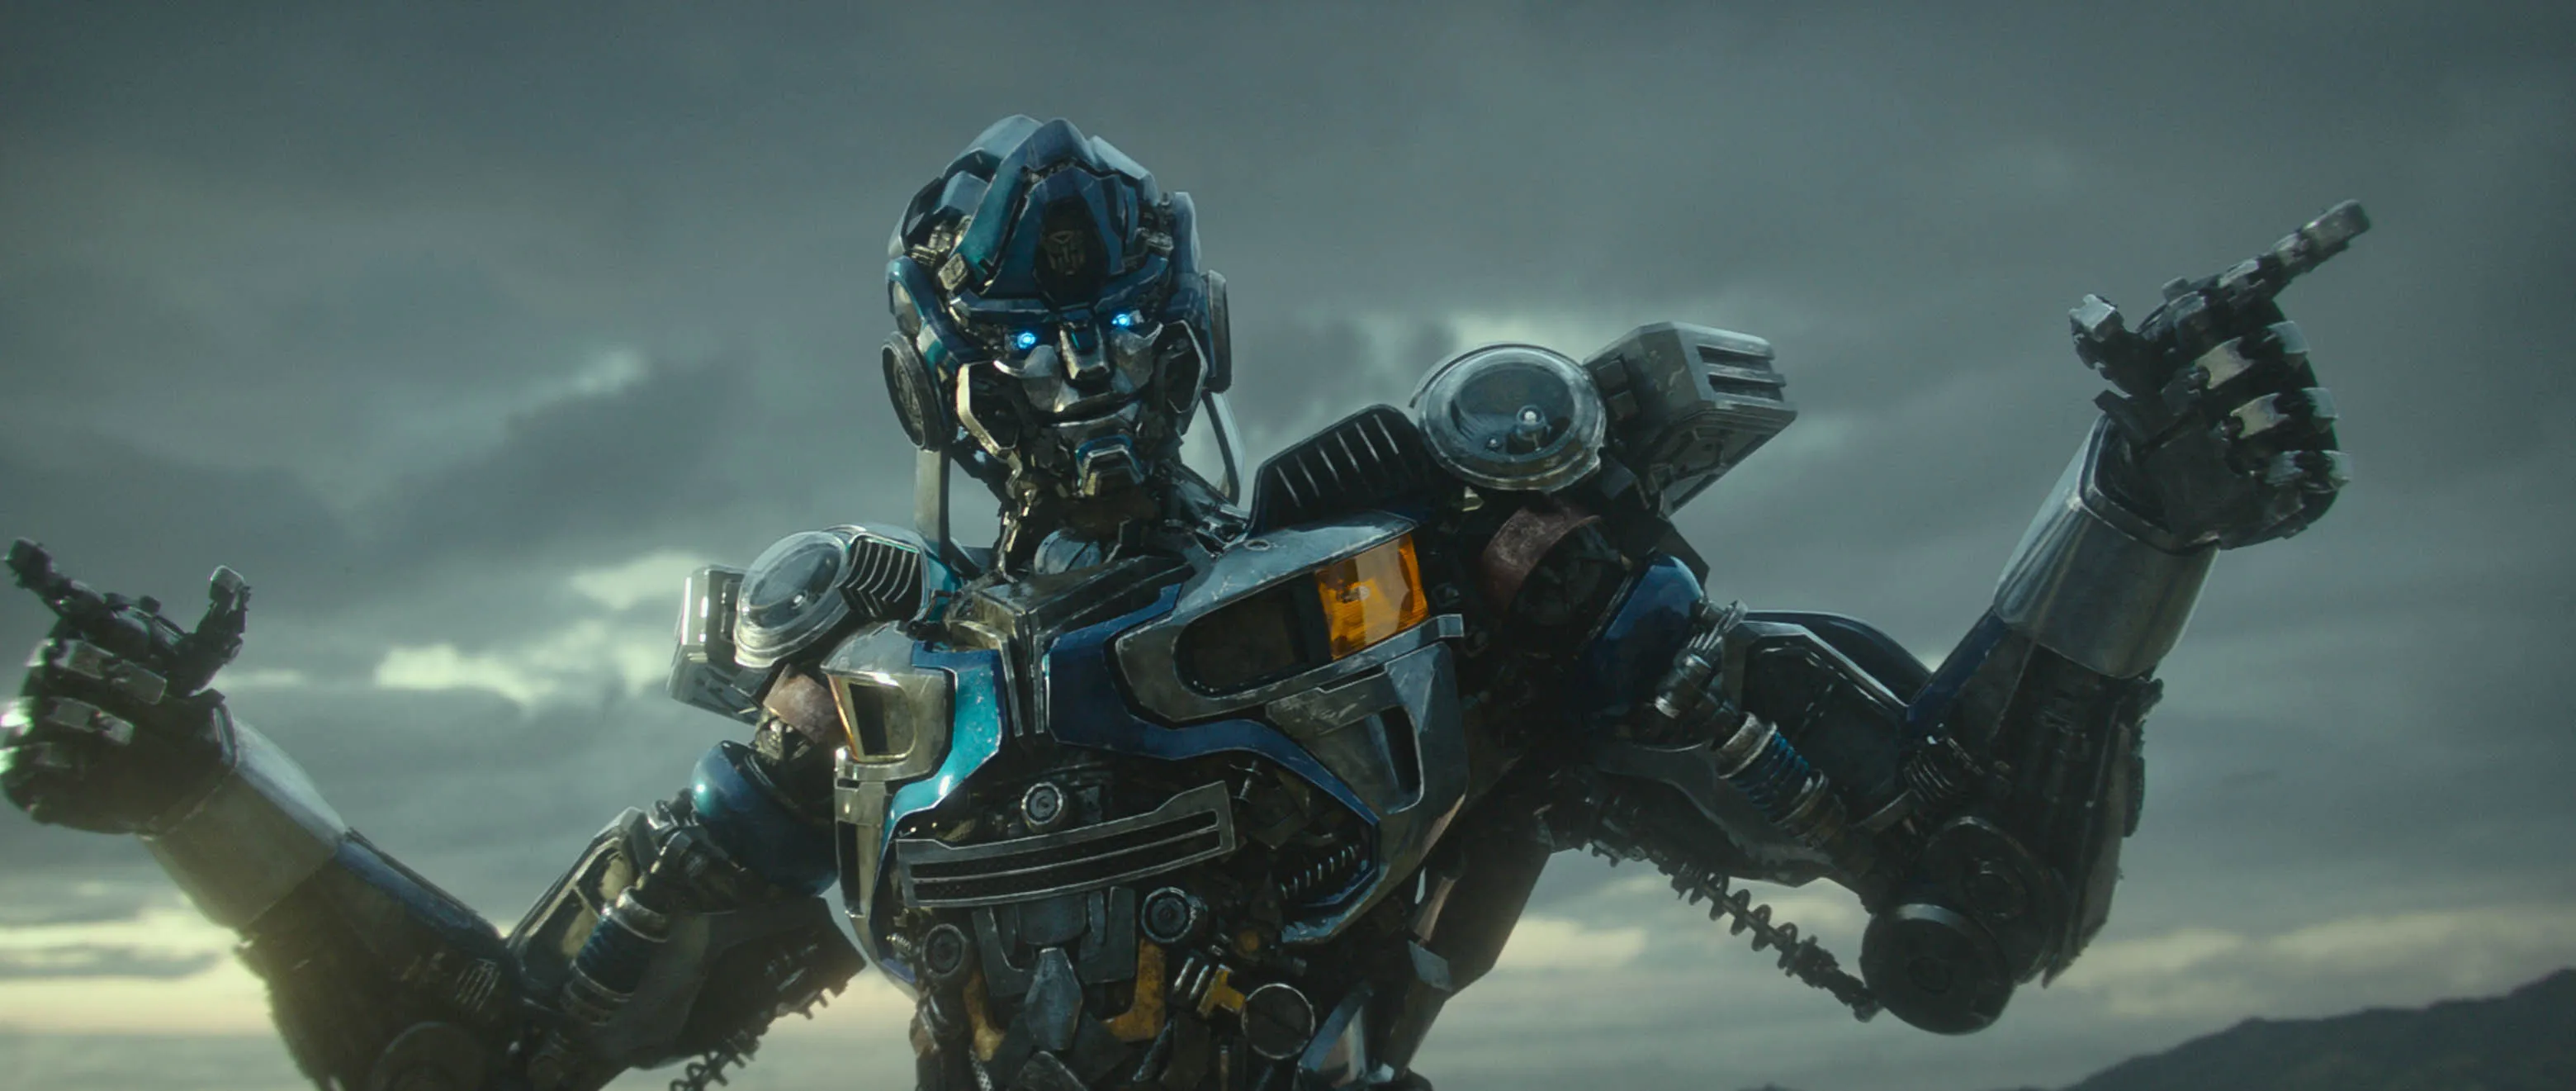

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Subword Tokenization</p>

Before we go through the model architecture, let's briefly talk about **tokenization**. So far we've mostly used **word level tokenization**. This is very effective because each word already carries a lot of informatino, however a down side is that it cannot handle **Out-Of-Vocabulary** (OOV) words. On the other hand there is **character level tokenization**, which can handle OOV words but needs to learn how to spell words correctly.

For the transformer, a **subword level tokenization** approach was used that takes the best of both worlds. The idea is to tokenize **common words** as they appear but break down rarer words into **subwords**. This is both efficient in that it retains the meaning of the most frequent words but can also handle OOV words by breaking them down into subwords. 

<br>
<center>
<img src="https://i.postimg.cc/x1bQ9QjW/subword-tokenization.jpg" width=600>
</center>
<br>

One algorithm used to figure out which words to keep and which to break down is called **Byte Pair Encoding** (BPE). This is a **data compression technique** that iteratively builds a vocabulary by **merging** the most frequent subwords that appear in the corpus. Alternatives to BPE include **Wordpiece** (used by BERT) and **Sentencepiece**, which work in the opposite direction, i.e. first tokenize words/sentences and then break these down into subwords. 

<br>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Non-Recurrence</p>

In the last two notebooks we saw how Recurrent Neural Networks (RNNs) **process text sequentially** via cells and hidden states. When they were first developed, researchers quickly noticed that they were **very slow** to train because calculations **couldn't be parallelized**. This is simply because each cell needed the hidden state of the **previous** cell before being able to produce its own hidden state.

This is where transformers come in. The groundbreaking idea in the *Attention is All You Need* paper was to completely **get rid of recurrence** in RNNs and instead use **all the inputs** to work out each output. They exact way this is done is called the **self attention mechanism**, which we will soon cover. 

This was an amazing **breakthrough** because it allowed for much **faster, parallelized training** across many GPUs. 

<br>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Self Attention</p>

Recall when we previously came across attention, the inputs were dotted together to create attention weights by passing these scores through a softmax. The weights were then used in a linear combination of the inputs to create the attention vector.

In the transformer, attention works in a similar way. The main difference is that the input is first multiplied by 3 matrices, $Q, K, V$ called the **query, key and value matrices** that act as **additional learnable parameters** than just the input embeddings. The intution is that a query is made against the key (like in a database), which is then used to select the appropriate value. 

<br>
<center>
<img src="https://i.postimg.cc/yxggGkMr/selfattention.jpg" width=600>
</center>
<br>

The **vectorized formula** is given by 

<br>
$$
\Large
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
<br>

What this is doing, is taking the **dot product** of all the query and key vectors (at the same time via matrix multiplication) and **scaling** these by the square root of the key $d_k$ size to normalize for different sequence lengths. The resulting scores are then passed through a **softmax** (applied row-wise) to create weights that sum to 1, which are used in a **linear combination** with the value vectors to output the attention vectors. 

This calculation is repeated for each time step, using the **same** Q, K and V matrices. Since the entire output is another sequence, it is common to **stack multiple attention layers** on top of each other. What we have described up to now is a **single attention head**.

<br>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Multi-Head Self Attention</p>

A single attention head will only be able to focus on a single aspect of how words related to each other in a sentence. But we know there are **multiple questions** we can ask when we read a sentence, for example, who, where what, when, why etc. 

For this reason, the transformer uses **multiple attention heads**, i.e. there are multiple sets of Q, K and V matrices that can each learn different relationships on their own in each layer. 

<br>
<center>
<img src="https://i.postimg.cc/DZZHtX2h/multiheadattention.png" width=250>
</center>
<br>

TO balance the additional **computational complexity**, if there are $h$ heads then the Q, K, V matrices have their embedding dimensions divided by $h$, i.e. the number of columns is divided by $h$. This means the total **number of learnable parameters stays the same**, which is allows for more complex relationships to be learnt at a comparable speed to before. 

The output of each head is **concatenated** and passed through a **fully connected layer** for further processing. The nice thing to remain is that the input and outputs share exactly the **same dimension**, so it is easy to stack multiple layers on top of each other for better performance. 

In the original transformer, the embedding dimension (aka **model dimension**) was $d_{\text{model}}=512$ and **8 attention heads** were used, so that each head had a dimension of 512/8 = 64.

<br>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Positional Encoding</p>

By removing recurrence, we have gained the ability to parallelize computations but this has come at the cost of **losing word order information**. At the moment, if we change the order of the input words we would get the same corresponding outputs but this is not how language works!

So we need a way to tell our model that **word order is important**. In the original paper, this was done by **adding a vector** to the input embeddings before the attention layer was computed. This positional encoding vector followed the following **sinusoidal equations**

<br>
$$
\text{PE}_{(pos, 2i)} = \sin(pos/10000^{2i/d_{\text{model}}}) \\
\text{PE}_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{\text{model}}})
$$
<br>

where $pos$ is the position and $i$ is the dimension. 

There are **two equations**, one for even dimensions and one for odd dimensions. The idea is that each dimension has its own **unique** sinusoidal function and each word in the sequence gets a different value depending on its position. 

<br>
<center>
<img src="https://i.postimg.cc/J7fxV2m0/positionalencoding.png" width=600>
</center>
<br>

The allows the transformer to learn **positional information** about each input sequence. Don't worry about where the 10,000 comes from - it is quite arbitrary. 

Note that nowaways it is more common to use a **learnable positional embedding** to apply a positional encoding instead of these sinusoidal curves. This works exactly the same as word embeddings where the model **learns** the best word order representations using **backpropagation**. 

<br>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Architecture</p>

We've now got all the pieces we need to understand the transformer architecture. The model is split into an **encoder and a decoder**. The encoder processes the input into some representation which the decoder uses to produce an output. 

We've already discussed how the inputs are first passed through an **embeddding layer** and combined with a **positional encoding** before being going through the first **encoder block**. 

The encoder block is made up of a **multi-head attention layer** followed by a two layered **feed forward neural network** applied pointwise. In the paper, the dimensions of the layers were 512 for the input layer, 2048 for the hidden layer and 512 for the output layer. Furthermore, the encoder was made up of **6 encoder blocks** stacked on top of each other.

<br>
<center>
<img src="https://i.postimg.cc/Ssq8WhD5/transformer.webp" width=350>
</center>
<br>

Because of the very deep architecture of the model, a couple additional tricks were used in training to stabilize the output. These were **layer normalization** and **skip connections**. Layer normalization is similar to batch normalization however instead of normalizing across each batch, it **normalizes across each layer** output making it easier to parallelize. 

Skip connections are a **technique from computer vision** that add the input of a layer to the output of following layer. This makes it **easier to train** very deep networks because the model can learn the **identity function** and pass information between layers more easily. In the original paper, these techniques were placed after each attention/feed forward layer however it is more common today to place them **before** these layers. 

The **decoder** works in a similar to the encoder but with some key differences. It starts with a **masked multi-head attention layer** because it won't be able to see into the future at inference time. For example, if we are doing translation then the decoder should only be using words that it has already translated so far. 

After that, just like in the decoder a **multi-head attention layer** and a **feed forward neural network** is used after that. The only difference is that the **keys and values matrices** from the encoder are used in the decoder attention layer. Again **6 decoder blocks** were used in the original paper. Finally, this is passed through a **linear layer** followed by a **softmax** to generate the outputs. 

<br>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Variants</p>

Quickly after the original paper came out, a whole host of **different transformers** were released. These can be categorized into **encoder only** (e.g. BERT), **decoder only** (e.g. GPT) and **encoder-decoder** (e.g. T5). Let's briefly discuss the main models and see how they are different to each other.

<br>
<center>
<img src="https://i.postimg.cc/fRT71vjr/transformer-groups.png" width=500>
</center>
<br>

**BERT** stands for Bidirectional Encoder Representations from Transformers and has up to **340 million parameters**. It was trained by a team at Google using **masked language modelling**, i.e. guess the missing word in a sentence. 

**DistilBERT** is a distilled version of BERT that achives 97% performance of BERT while being **60% faster**. It can be used for text classification and sequence labelling tasks. 

**RoBERTa** is similar to BERT but was trained for much longer and with better design choices. It significantly **exceeded the performance** of BERT on some tasks. 

**XLM** is a **cross-lingual language model** variant of BERT that smashed several benchmarks on multilingual and translation tasks. 

**ALBERT** is an optimized version of BERT that used **fewer parameters** thus making it possible to train larger models with fewer parameters. 

**GPT** stands for Generative Pre-trained Transformer and is a family of decoder only transformers developed by OpenAI and used for **text generation** tasks. These were trained on **next word prediction** and are able to produce coherent text thanks to its enormous model size (GPT-3 has **175 billion parameters**!). 

**T5** is a high-performing encoder-decoder transformer based on the original paper and is used for **sequence-to-sequence tasks**.  

# Application

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Transformers from scratch</p>

To reinforce our understanding of transformers, lets write the code to **implement one from scratch**. We wont't be able to train it on our own but we will later see how was can use **transfer learning** to fine tuning a pre-trained transformer for our applications. 

**Libraries**

In [ ]:
import numpy as np
import tensorflow as tf

**Multi-Head Attention**

This implementation of Multi-Head Attention uses the **same Q, K, V matrices** in each head. It also allows for inputs corresponding to padding to be **masked out**. 

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # Head dimension
        self.d_head = self.d_model // self.num_heads

        # Trainable parameters
        self.Wq = tf.keras.layers.Dense(self.d_model)
        self.Wk = tf.keras.layers.Dense(self.d_model)
        self.Wv = tf.keras.layers.Dense(self.d_model)
        
        # Fully connected layer
        self.dense = tf.keras.layers.Dense(self.d_model)
  
    # Scaled dot product attention
    def attention(self, query, key, value, mask=None):
        key_dim = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = tf.matmul(query, key, transpose_b=True) / np.sqrt(key_dim)

        if mask is not None:
            scaled_scores = tf.where(mask==0, -np.inf, scaled_scores)

        softmax = tf.keras.layers.Softmax()
        weights = softmax(scaled_scores)
        return tf.matmul(weights, value), weights

    # Reshape and transpose Q, K, V
    def split_heads(self, x):
        batch_size = x.shape[0]

        split_inputs = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_head))
        return tf.transpose(split_inputs, perm=[0, 2, 1, 3])
    
    # Reverses previous function
    def merge_heads(self, x):
        batch_size = x.shape[0]

        merged_inputs = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(merged_inputs, (batch_size, -1, self.d_model))

    # Forward pass
    def call(self, q, k, v, mask):
        Q = self.Wq(q)
        K = self.Wk(k)
        V = self.Wv(v)

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        output, attention_weights = self.attention(Q, K, V, mask)
        output = self.merge_heads(output)

        return self.dense(output), attention_weights

**Encoder block**

Like in the original paper, **dropout** is applied between layers. 

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffnn = self.feed_forward_neural_network(d_model, hidden_dim)
    
        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
        # Layer normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
  
    # Feed forward neural network
    def feed_forward_neural_network(self, d_model, hidden_dim):
        return tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(d_model)])

    # Forward pass
    def call(self, x, mask):
        mha_output, attention_weights = self.mha(x, x, x, mask)
        mha_output = self.dropout1(mha_output)
        mha_output = self.layernorm1(x + mha_output)

        ffnn_output = self.ffnn(mha_output)
        ffnn_output = self.dropout2(ffnn_output)
        output = self.layernorm2(mha_output + ffnn_output)

        return output, attention_weights

**Encoder**

Recall that it is more common to use a **trainable embedding layer** for the positional encoding, which is what we will use here. Note also that the paper applied **dropout** to the embeddings before the encoder blocks. 

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, src_vocab_size,
               max_seq_len, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Embedding layers
        self.token_embed = tf.keras.layers.Embedding(src_vocab_size, self.d_model)
        self.positional_embed = tf.keras.layers.Embedding(max_seq_len, self.d_model)

        # Dropout
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        # Encoder blocks
        self.blocks = [EncoderBlock(self.d_model, num_heads, hidden_dim, dropout_rate) 
                        for _ in range(num_blocks)]
  
    # Forward pass
    def call(self, inpt, mask):
        token_embeds = self.token_embed(inpt)

        # Position indices for batch of input sequences
        num_pos = inpt.shape[0] * self.max_seq_len
        pos_idx = np.resize(np.arange(self.max_seq_len), num_pos)
        pos_idx = np.reshape(pos_idx, inpt.shape)
        pos_embeds = self.pos_embed(pos_idx)

        x = self.dropout(token_embeds + pos_embeds)

        # Pass input through decoder blocks
        for block in self.blocks:
            x, weights = block(x, mask)

        return x, weights

**Decoder block**

In [ ]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffnn = self.feed_forward_neural_network(d_model, hidden_dim)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.layernorm3 = tf.keras.layers.LayerNormalization()
  
    # Feed forward neural network
    def feed_forward_neural_network(self, d_model, hidden_dim):
        return tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(d_model)])

    # Forward pass
    def call(self, encoder_output, target, decoder_mask, memory_mask):
        mha_output1, attention_weights = self.mha1(target, target, target, decoder_mask)
        mha_output1 = self.dropout1(mha_output1)
        mha_output1 = self.layernorm1(mha_output1 + target)

        mha_output2, attention_weights = self.mha2(mha_output1, encoder_output, 
                                                encoder_output, memory_mask)
        mha_output2 = self.dropout2(mha_output2)
        mha_output2 = self.layernorm2(mha_output2 + mha_output1)

        ffnn_output = self.ffnn(mha_output2)
        ffnn_output = self.dropout3(ffnn_output)
        output = self.layernorm3(ffnn_output + mha_output2)
        return output, attention_weights

**Decoder**

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, target_vocab_size,
               max_seq_len, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_embed = tf.keras.layers.Embedding(target_vocab_size, self.d_model)
        self.pos_embed = tf.keras.layers.Embedding(max_seq_len, self.d_model)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.blocks = [DecoderBlock(d_model, num_heads, hidden_dim, dropout_rate) for _ in range(num_blocks)]

    def call(self, encoder_output, target, decoder_mask, memory_mask):
        token_embeds = self.token_embed(target)

        # Position indices for batch of sequences
        num_pos = target.shape[0] * self.max_seq_len
        pos_idx = np.resize(np.arange(self.max_seq_len), num_pos)
        pos_idx = np.reshape(pos_idx, target.shape)
        pos_embeds = self.pos_embed(pos_idx)

        x = self.dropout(token_embeds + pos_embeds)

        for block in self.blocks:
            x, weights = block(encoder_output, x, decoder_mask, memory_mask)

        return x, weights

**Transfomer**

Putting the pieces together, we have arrived at the transformer model. 

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, source_vocab_size,
               target_vocab_size, max_input_len, max_target_len, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_blocks, d_model, num_heads, hidden_dim, source_vocab_size, 
                               max_input_len, dropout_rate)

        self.decoder = Decoder(num_blocks, d_model, num_heads, hidden_dim, target_vocab_size,
                               max_target_len, dropout_rate)
    
        # Final output layer
        self.output_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, input_seqs, target_input_seqs, encoder_mask, decoder_mask, memory_mask):
        encoder_output, encoder_attention_weights = self.encoder(input_seqs, encoder_mask)

        decoder_output, decoder_attention_weights = self.decoder(encoder_output, target_input_seqs,
                                                            decoder_mask, memory_mask)

        return self.output_layer(decoder_output), encoder_attention_weights, decoder_attention_weights

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Fine-tuning</p>

Training a transformer from scratch requires **lots of data and compute**, which can be expensive. Luckily, we can use **transfer learning** to leverage **pre-trained** transformer models and **fine-tune** these for our specific application.

The idea is to add a new **classification head** on top of a pre-trained model and then train the entire model whilst using a **different learning rate** for each layer. In general, the closer the layer is to the input sequence the smaller the learning rate will be. 

Let's see how to do this using the **Hugging Face** ecosystem, which is a company that aims to make machine learning accessible to everyone. In particular, we will download a **pre-trained DistilBERT model** and fine-tune this on a **sentiment analysis** task. 

<br>

**Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import datasets
from datasets import load_dataset

**Load data**

<br>

The dataset is from my beginner friendly [NLP competition on sentiment analysis](https://www.kaggle.com/competitions/sentiment-analysis-company-reviews) I am currently hosting. 

In [ ]:
# Load data
train = pd.read_csv("/kaggle/input/sentiment-analysis-company-reviews/train.csv")
test = pd.read_csv("/kaggle/input/sentiment-analysis-company-reviews/test.csv")
sub = pd.read_csv("/kaggle/input/sentiment-analysis-company-reviews/sample_submission.csv")

# Preview data
print(train.shape)
train.head(5)

In [ ]:
# Explore target distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x="Rating")
plt.title("Target distribution")
plt.show()

**Pre-process data**

<br>

We have to make some **small changes** to our dataset so it is compatible with the Hugging Face dataset object.

In [ ]:
# Map labels
train["Rating"] = train["Rating"] - 1

# Create validation set
X_train, X_valid, _, _ = train_test_split(train, train["Rating"], test_size=0.2, shuffle=True, random_state=0)

# Save to csv
X_train[["Review","Rating"]].rename(columns={"Review":"text", "Rating":"label"}).to_csv("new_train.csv", index=False)
X_valid[["Review","Rating"]].rename(columns={"Review":"text", "Rating":"label"}).to_csv("new_valid.csv", index=False)
test[["Review"]].rename(columns={"Review":"text"}).to_csv("new_test.csv", index=False)

**Datasets**

<br>

Now we can load our data into Hugging Face datasets, which makes it easier to interact with their models. 

In [ ]:
# Create datasets
train_ds = load_dataset("csv", data_files={"train": "new_train.csv"})
valid_ds = load_dataset("csv", data_files={"valid": "new_valid.csv"})
test_ds = load_dataset("csv", data_files={"test": "new_test.csv"})

# Define features and target
train_ds = train_ds.cast(datasets.Features({"text": datasets.Value("string"), "label": datasets.ClassLabel(num_classes=5)}))
valid_ds = valid_ds.cast(datasets.Features({"text": datasets.Value("string"), "label": datasets.ClassLabel(num_classes=5)}))

# Print summary
print(train_ds)
print(valid_ds)
print(test_ds)

**Tokenizer**

<br>

Hugging Face has this amazing feature called **AutoTokenizer** that given the model name, returns the precise tokenizer used for training that model. 

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Tokenization is applied in batches and the end result is saved as a **new feature** in the datasets.

In [ ]:
# Tokenize batch
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Apply tokenization
batch_size = 32
train_encoded = train_ds.map(tokenize, batched=True, batch_size=batch_size)
valid_encoded = valid_ds.map(tokenize, batched=True, batch_size=batch_size)
test_encoded = test_ds.map(tokenize, batched=True, batch_size=batch_size)

**Model**

<br>

We will be using the pre-trained `distilbert-base-uncased` model. This is a **distilled version** of BERT that also doesn't make a difference between upper and lower cases. 

In [ ]:
# Connect to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download model
num_labels = 5
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

**Metrics**

<br>

These get computed at the end of every epoch on the validation dataset. We've added in the competition metric, which is Mean Absolute Error (MAE).

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    mae = mean_absolute_error(labels, preds)
    return {"mae": mae, "accuracy": acc, "f1": f1}

**Train model**

<br>

Training a model is made easy using Hugging Face with their Train helper function. 

In [ ]:
logging_steps = len(train_encoded["train"]) // batch_size
model_name_out = f"{model_name}-finetuned-emotion"

# Training hyper-parameters
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [ ]:
# Define trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded["train"],
                  eval_dataset=valid_encoded["valid"],
                  tokenizer=tokenizer)

# Train model
trainer.train()

**Evaluate**

<br>

Let's evaluate our model using the validation set.

In [ ]:
# Predictions on validation set
valid_preds = trainer.predict(valid_encoded["valid"])
valid_preds = np.argmax(valid_preds.predictions, axis=1)

# Ground truth labels
y_valid = np.array(valid_ds["valid"]["label"])
labels = train_ds["train"].features["label"].names

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

plot_confusion_matrix(valid_preds, y_valid, labels)

**Test set predictions**

<br>

At the time of making this notebook, these predictions would put you in **1st place** of the competition. (I won't submit them since I am the host but feel free to do this yourself).

In [ ]:
# Test set predictions
preds = trainer.predict(test_encoded["test"])
test_preds = np.argmax(preds.predictions, axis=1)

In [ ]:
# Distribution of predictions
plt.figure(figsize=(10,4))
sns.histplot(test_preds+1)
plt.title("Distribution of final predictions")
plt.show()

In [ ]:
# Save predictions to csv
sub["Rating"] = test_preds+1
sub.to_csv("submission.csv", index=False)